<img align="center" src="http://sydney.edu.au/images/content/about/logo-mono.jpg">
<h1 align="center" style="margin-top:10px">Statistical Learning and Data Mining (QBUS6810)</h1>
<h2 align="center" style="margin-top:10px">Tutorial 4: Linear regression and K-nearest neighbours</h2>
<br>


In this tutorial we will use the K-nearest neigbours regression method (together with OLS) to illustrate several key steps of a  machine learning project: splitting a dataset into training and test sets, making predictions,and evaluating generalisation performance. We will also illustrate oither important practical aspects of modelling, such as using exploratory data analysis.


<a href="#Credit-Card-Data">Credit Card Data</a> <br>
<a href="#Training-and-Test-Sets">Training and Test Sets</a> <br>
<a href="#Exploratory-Data-Analysis">Exploratory Data Analysis</a> <br>
<a href="#Data-Preparation">Data Preparation</a> <br>
<a href="#Linear-Regression">Linear Regression</a> <br>
<a href="#K-Nearest-Neighbours-Regression">K-Nearest Neighbours Regression</a> <br>
<a href="#Model-Evaluation">Model Evaluation</a> <br>


This notebook relies on the following imports and setting. We will load new functions and libraries in context to make clear what we are using them for. 

In [9]:
# Packages
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore') # this is to clear the warnings from this page, usually we should leave them on

In [2]:
# Plot settings
sns.set_context('notebook') # optimise figures for notebook display
sns.set_style('ticks') # set default plot style
colours = ['#1F77B4', '#FF7F0E', '#2CA02C', '#DB2728', '#9467BD', '#8C564B', '#E377C2','#7F7F7F', '#BCBD22', '#17BECF']
crayon = ['#4E79A7','#F28E2C','#E15759','#76B7B2','#59A14F', '#EDC949','#AF7AA1','#FF9DA7','#9C755F','#BAB0AB']
sns.set_palette(colours) # set custom color scheme
%matplotlib inline
plt.rcParams['figure.figsize'] = (9, 6)

## Credit Card Data

We will again work with the <TT>Credit</TT> dataset from Weeks 1 and 2. The objective is to predict the average monthly credit card balance of customers based on predictors such as income, age, education, and credit rating. The dataset records the average credit card balace at end of the month for customers of a financial services company, as well as other individual characteristics such age, education, gender, marital status, number of cards, and credit rating.

We start by loading and viewing the data.

In [3]:
# We will always assume that the data file is in a subdirectory called "Datasets"

data=pd.read_csv('Datasets/Credit.csv', index_col='Obs')
data.head(10)

,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity,Balance
Obs,,,,,,,,,,,
1,14.891,3606,283,2,34,11,Male,No,Yes,Caucasian,333
2,106.025,6645,483,3,82,15,Female,Yes,Yes,Asian,903
3,104.593,7075,514,4,71,11,Male,No,No,Asian,580
4,148.924,9504,681,3,36,11,Female,No,No,Asian,964
5,55.882,4897,357,2,68,16,Male,No,Yes,Caucasian,331
6,80.180,8047,569,4,77,10,Male,No,No,Caucasian,1151
7,20.996,3388,259,2,37,12,Female,No,No,African American,203
8,71.408,7114,512,2,87,9,Male,No,No,Asian,872
9,15.125,3300,266,5,66,13,Female,No,No,Caucasian,279


## Training and Test Sets

As in the previous tutorial, we use the Scikit-Learn <a href="http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html" target="_blank"><TT>train_test_split</TT></a> method to split the data into training and test sets. 

In [4]:
from sklearn.model_selection import train_test_split

# Randomly split indexes
index_train, index_test  = train_test_split(np.array(data.index), train_size=0.7, random_state=1)

# Write training and test sets 
train = data.loc[index_train,:].copy()
test =  data.loc[index_test,:].copy()

## Exploratory Data Analysis

We start by computing the descriptive statistics and pairwise correlations for the numerical variables.

The count row in the first table shows the number available observations for each variable. In this case all variables have the same count, reassuring us that there are no missing values.  The response has a large standard deviation relative to the mean: we should keep the magnitudes in mind when discussing coefficient sizes and prediction errors.  The first quartile of the response is zero, indicating that substantial fraction of the credit card customers have zero or low balance. 

In [5]:
train.describe().round(1) # rounding the table to one decimal digit

,Income,Limit,Rating,Cards,Age,Education,Balance
count,280.0,280.0,280.0,280.0,280.0,280.0,280.0
mean,44.7,4690.0,352.0,3.0,55.4,13.5,509.3
std,34.6,2250.3,151.9,1.4,17.9,3.1,454.2
min,10.4,855.0,103.0,1.0,23.0,5.0,0.0
25%,21.0,3072.0,241.2,2.0,40.0,11.0,51.5
50%,33.1,4654.0,343.0,3.0,56.0,14.0,453.5
75%,55.4,5833.5,435.5,4.0,70.2,16.0,843.8
max,186.6,13913.0,982.0,9.0,98.0,20.0,1999.0


The pairwise correlations reveal that the predictors that are most correlated with the response are limit, rating, and income. The remaining predictors have very low correlation with credit card balances. Another important finding is that limit and rating have nearly perfect positive correlation and are therefore redudant predictors. Also note that income is highly correlated with limit and rating. Limit seems to be the key linear predictor of the response. 

In [6]:
train.corr().round(2)

,Income,Limit,Rating,Cards,Age,Education,Balance
Income,1.00,0.79,0.78,0.01,0.16,0.01,0.46
Limit,0.79,1.00,1.00,0.03,0.12,0.01,0.87
Rating,0.78,1.00,1.00,0.08,0.12,0.01,0.87
Cards,0.01,0.03,0.08,1.00,0.04,-0.02,0.11
Age,0.16,0.12,0.12,0.04,1.00,0.03,0.03
Education,0.01,0.01,0.01,-0.02,0.03,1.00,0.03
Balance,0.46,0.87,0.87,0.11,0.03,0.03,1.00


We now investigate the (unconditional) distribution of the response by plotting a histogram. We find that the response has a pronouncedly right skewed distribution. A substantial number of customers have zero or low credit card balance. 

In [10]:
from statlearning import plot_histogram
# statlearning is our custom library, you need to download the statlearning.py file 
# and have it in the same directory as you are running this notebook from

fig, ax = plot_histogram(train['Balance'])
ax.set_title('Distribution plot for customer credit card balance')
plt.show()

ModuleNotFoundError: No module named 'statsmodels'

**Note about plotting figures**

In general, the tutorial notebooks will provide code for figures that include customisation, which is done for aesthetic reasons.  It will be clear which parts are for customisation, and it is up to you to choose the level that you are comfortable with. If you are just getting started, you may want to keep things simpler.  For example, this would be the minimal code if we just want to plot the histogram from above without worrying about details. 

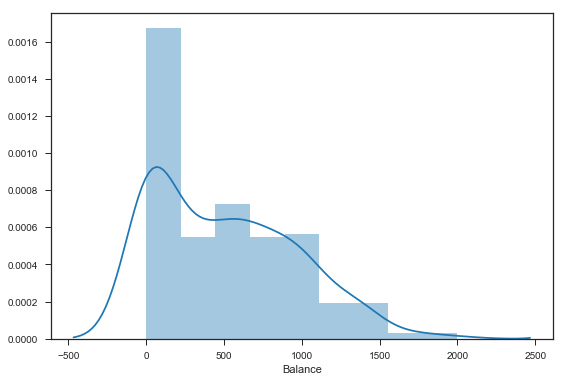

In [8]:
sns.distplot(train['Balance'])
plt.show()

A scatter plot of credit limit vs. credit balance reveals that there is a nonlinear relatioship between these two variables. Furtheremore, there are several clients with a response value of zero.

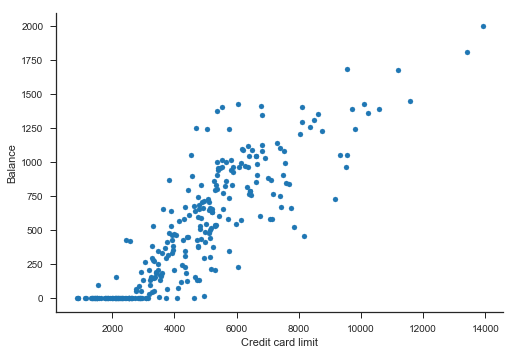

In [9]:
fig, ax = plt.subplots(figsize=(8,5.5))
plt.scatter(train['Limit'], train['Balance'], s=25) # the s option is the size of the dot
ax.set_xlabel('Credit card limit')
ax.set_ylabel('Balance')
sns.despine()
plt.show()

The next cell illustrates how we can create a figure to explore the relationship between a quantitative variable and a variable with a reasonably small number of distinct values. 

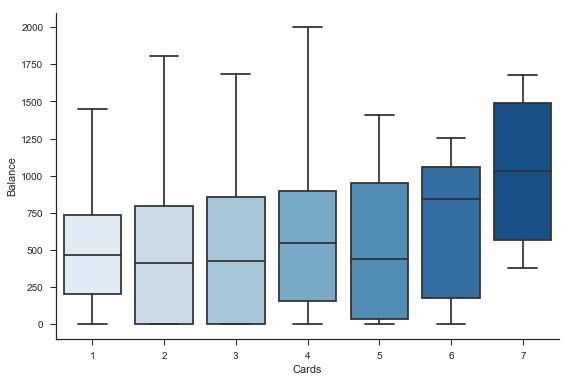

In [10]:
rows=train['Cards']<=7 # too few observations for more than 7 cards, so we focus on those with at most 7
sns.boxplot(x=train.loc[rows,'Cards'], y=train.loc[rows,'Balance'], palette='Blues')
sns.despine()
plt.show()

## Data Preparation

We need to identify and separate the response and the predictors. We will start with just one predictor: customer's credit card Limit. 

In [21]:
# Construting response vector and design matrix (matrix of predictor values) 
response = 'Balance'
predictors = ['Limit',] # in general we will be working with a list of predictors, even though we only have one here

# If we wanted to use all available predictors, we would define predictors as follows: 
# predictors = [variable for variable in train.columns if variable!=response]

y_train = train[response] # selects the response variable
X_train=train[predictors].copy() # selects the variables in the predictor list

y_test = test[response]
X_test=test[predictors].copy()

## Linear Regression

Scikit-Learn library allows us to train and use a wide range of machine learning algorithms using a simple syntax structure: 

1. Import the method.<br>
2. Specify the model and options.
3. Train the model.
4. Use the estimated model to make predictions. 

We start with a basic method: linear regression. From here on we will use the <a href="http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html" target="_blank"><TT>LinearRegression</TT></a> function from Scikit-Learn the to train linear regression models. 

In [22]:
from sklearn.linear_model import LinearRegression
ols = LinearRegression()
ols.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Suppose that we want to predict the credit card balance of a customer that has a limit of 5000 dollars.

In [13]:
ols.predict(5000)

array([563.40720662])

Let's visualise the trained model. 

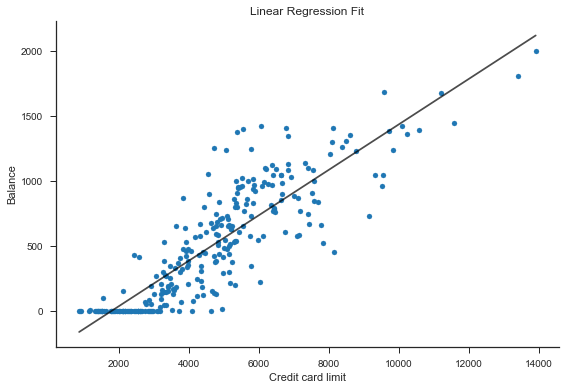

In [14]:
# Here, we generate a grid of 500 values ranging from the minimum to the maximum value of the variable in the training data
x = np.linspace(X_train.min(), X_train.max(), 500).reshape((-1,1))

# Compute the predicted values for each of these input points
y_pred = ols.predict(x)

# Figure
fig, ax = plt.subplots()
ax.scatter(X_train.values, y_train.values, s=25) # the s option is the size of the dot
ax.set_title("Linear Regression Fit")
ax.set_xlabel('Credit card limit')
ax.set_ylabel('Balance')
ax.plot(x, y_pred, color='black', alpha = 0.7)
sns.despine()
plt.show()

## K-Nearest Neighbours Regression

The previous figure suggests that the linear regression model may not be satisfactory for this data, since the relationship between limit and balance appears to be nonlinear. The <a href="http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html" target="_blank"><TT>K-Nearest Neighbours</TT></a> (KNN) method is a flexible algorithm that can approximate complex relationships between the response and predictors without assuming a particular form for the regression function.
    
Using the KNN method with Scikit-Learn follows the template from above. Unlike in the linear regression model, however, we need to specify a tuning parameter: the number of neighbours. 

In [25]:
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor(n_neighbors=10) # we should specify the number of neighbours
knn.fit(X_train, y_train)
knn.predict(5000)

array([559.6])

Let's visualise the relationship fitted by K-Nearest Neighbours algorithm using K=10 neighbours. 

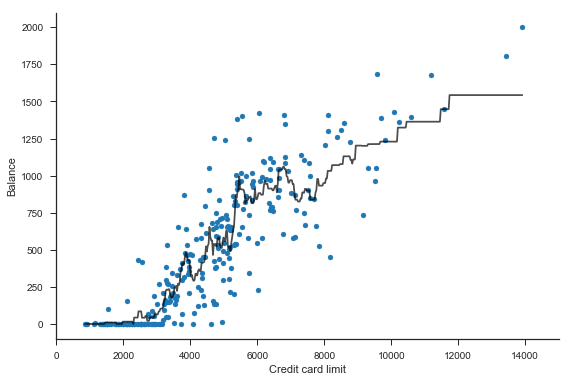

In [16]:
# Generate a grid of 500 values ranging from the minimum to the maximum value of the variable in the training data
x = np.linspace(train['Limit'].min(),train['Limit'].max(), 500).reshape((-1,1))

# Compute the predicted values for each of these input points
y_pred = knn.predict(x)

# Plot figure
fig, ax = plt.subplots()
ax.scatter(X_train.values, y_train.values, s=25) # the s option is the size of the dot
ax.set_xlabel('Credit card limit')
ax.set_ylabel('Balance')
ax.set_xlim(0, 15000)
ax.plot(x, y_pred, color='black', alpha = 0.7)
sns.despine()
plt.show()

<br>

*** Excercise. ***
Check how the above plot changes when you change the number of neighbors (between 1 and 280, which is the number of training observations).

<br>
The K-Nearest Neighbours fit depends strongly on the choice the number of neighbours. As illustrated below, choosing K=2 leads to overfitting, while K=50 underfits the training data. 

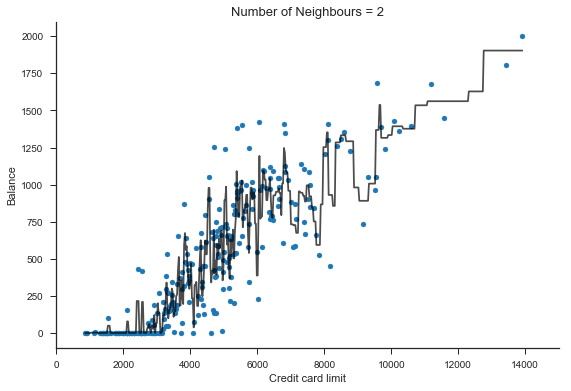

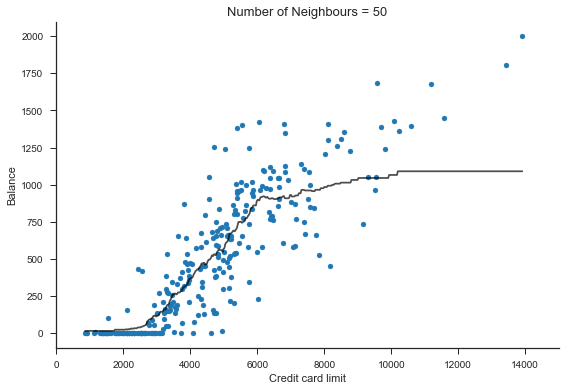

In [17]:
for K in [2, 50]:
    
    # Specify and fit model
    knn = KNeighborsRegressor(n_neighbors=K) 
    knn.fit(X_train, y_train)

    # Compute the predicted values for each point in the grid
    y_pred = knn.predict(x)

    # Plot figuer
    fig, ax = plt.subplots()
    ax.scatter(X_train.values, y_train.values, s=25) 
    ax.set_title(f'Number of Neighbours = {K}', fontsize=13)
    ax.set_xlabel('Credit card limit')
    ax.set_ylabel('Balance')
    ax.set_xlim(0, 15000)
    ax.plot(x, y_pred, color='black', alpha = 0.7)
    sns.despine()
    plt.show()

## Model Evaluation

We now assess the performance of the K-NN method with 10 neighbours on the test data, also displaying the results for the linear regression for comparison. The results confirm that we made a good choice by selecting the KNN as the model to predict new data. 

In [18]:
from sklearn.metrics import mean_squared_error, r2_score

knn = KNeighborsRegressor(n_neighbors=10) # we should specify the number of neighbours

# Training
ols.fit(X_train, y_train)
knn.fit(X_train, y_train)

# Initialise table
columns=['RMSE', 'R-Squared']
rows=['Linear Regression', 'K-NN']
results =pd.DataFrame(0.0, columns=columns, index=rows)

# List algorithms
methods = [ols, knn] 

# Computer test predictions and metrics
for i, method in enumerate(methods):
    y_pred = method.predict(X_test)
    results.iloc[i, 0] = np.sqrt(mean_squared_error(y_test, y_pred))
    results.iloc[i, 1] = r2_score(y_test, y_pred)

results.round(2)

,RMSE,R-Squared
Linear Regression,246.51,0.73
K-NN,235.76,0.75




*** Using more than one predictor *** .  Now that we understand how the basic process works, we can consider building upon this basic model, for example by adding other predictors. In the EDA with saw that customer income has the second strongst correlation with the response, so that a natural step would be to add it to the model. Because income and limit are on different scales, and are highly correlated, this is only going to work well if we use the [Mahalanobis distance](https://en.wikipedia.org/wiki/Mahalanobis_distance), instead of the Euclidean distance, in the KNN specification.

In [19]:
predictors = ['Limit','Income'] 

X_train=train[predictors].copy() 
X_test=test[predictors].copy()

knn2 = KNeighborsRegressor(n_neighbors = 10, metric='mahalanobis', metric_params={'V': X_train.cov()}) 

*** Model Evaluation *** . We now assess the performance of the K-NN method with 2 predictors and 10 neighbours on the test data, also displaying the results for the linear regression for comparison. 

In [20]:
# Training
knn2.fit(X_train, y_train)
ols.fit(X_train, y_train)

# Initialise table
columns=['RMSE', 'R-Squared']
rows=['Linear Regression (2 predictors)', 'K-NN (2 predictors)']
results =pd.DataFrame(0.0, columns=columns, index=rows)

# List algorithms
methods = [ols, knn2] 

# Computer test predictions and metrics
for i, method in enumerate(methods):
    y_pred = method.predict(X_test)
    results.iloc[i, 0] = np.sqrt(mean_squared_error(y_test, y_pred))
    results.iloc[i, 1] = r2_score(y_test, y_pred)

results.round(2)

,RMSE,R-Squared
Linear Regression (2 predictors),168.12,0.87
K-NN (2 predictors),160.01,0.88


<br><br><br>

*** Excercise. ***
Complete the following code to generate a plot of the test performance for the KNN model with one predictor as we change the number of neighbours.

In [ ]:
values = np.arange(1, 101)

rmses = []
for k in values: 
    # 1. Specify and fit the model on the training data (there is no need to store it)
    # 2. Compute predictions for the test data
    # 3. Compute the root mean squared error and assign to a variable called rmse
    rmses.append(rmse)
    
fig, ax= plt.subplots()
ax.plot(values, rmses)
ax.set_xlabel('Number of neighbours')
ax.set_ylabel('Test RMSE')
plt.show()

<br>
The following will give you the value of $k$  with lowest test error:

In [ ]:
1 + np.argmin(rmses)